# TB Drug Susceptibility Mutations

In [1]:
# Import Statements
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
cwd = Path.cwd()

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [2]:
df = pd.read_csv('filtered.csv')

# Remove 1 entry with NA PROVEAN output
df = df.dropna()

X = df[['original', 'new']]
effect_score = df['effect score']
effect = df['effect']
ligand_binding = df['ligand_binding']
y = df['drug']

In [3]:
aa_prop = X.replace({'Gly': 'non-polar', 'Ala': 'non-polar', 'Val': 'non-polar', 'Cys': 'non-polar', 'Pro': 'non-polar', 
                      'Leu': 'non-polar', 'Ile': 'non-polar', 'Met': 'non-polar', 'Trp': 'non-polar', 'Phe': 'non-polar', 
                      'Ser': 'polar', 'Thr': 'polar', 'Tyr': 'polar', 'Asn': 'polar', 'Gln': 'polar', 
                      'Lys': 'pos', 'Arg': 'pos', 'His': 'pos', 'Asp': 'neg', 'Glu': 'neg'})
aa_prop.columns = ['Original Property', 'New Property']

In [5]:
def get_polarity(x):
    if x[0] == 'non-polar' and x[1] != 'non-polar':
        return 1
    elif x[0] != 'non-polar' and x[1] == 'non-polar':
        return -1
    else:
        return 0
    
polarity = aa_prop.apply(get_polarity, axis=1)
polarity.name = 'Polarity Change'

In [6]:
# Hydrophobic = -1, Hydrophilic = 1
hydrophobic = X.replace({'Gly': -1, 'Ala': -1, 'Val': -1, 'Cys': -1, 'Pro': -1, 
                          'Leu': -1, 'Ile': -1, 'Met': -1, 'Trp': -1, 'Phe': -1, 
                          'Ser': 1, 'Thr': 1, 'Tyr': 1, 'Asn': 1, 'Gln': 1, 
                          'Lys': 1, 'Arg': 1, 'His': 1, 'Asp': 1, 'Glu': 1})

hydrophobic.columns = ['Original Hydrophobicity', 'New Hydrophobicity']

In [7]:
def get_hydrophobic(x):
    if x[0] == -1 and x[1] == 1:
        return 1
    if x[0] == 1 and x[1] == -1:
        return -1
    else:
        return 0
    
hydrophobic_change = hydrophobic.apply(get_hydrophobic, axis=1)
hydrophobic_change.name = 'Hydrophobicity Change'

In [8]:
def get_charge(x):
    if x[0] == 'pos' and (x[1] == 'non-polar' or x[1] == 'polar'):
        return -1
    elif x[0] == 'pos' and x[1] == 'neg':
        return -2
    elif x[0] == 'neg' and (x[1] == 'non-polar' or x[1] == 'polar'):
        return 1
    elif x[0] == 'neg' and x[1] == 'pos':
        return 2
    elif (x[0] == 'non-polar' or x[0] == 'polar') and x[1] == 'pos':
        return 1
    elif (x[0] == 'non-polar' or x[0] == 'polar') and x[1] == 'neg':
        return -1
    
    else:
        return 0
    
charge = aa_prop.apply(get_charge, axis=1)
charge.name = 'Charge Change'

In [9]:
mw = X.replace({'Gly': 75, 'Ala': 89, 'Val': 117, 'Cys': 121, 'Pro': 115, 
                      'Leu': 131, 'Ile': 131, 'Met': 149, 'Trp': 204, 'Phe': 165, 
                      'Ser': 105, 'Thr': 119, 'Tyr': 181, 'Asn': 132, 'Gln': 146, 
                      'Lys': 146, 'Arg': 174, 'His': 155, 'Asp': 133, 'Glu': 147})
mw.columns = ['Original MW', 'New MW']

mw_change = mw['New MW'] - mw['Original MW']
mw_change.name = 'MW Change'

### Combine Features

In [10]:
X = pd.concat([X, aa_prop, polarity, hydrophobic, hydrophobic_change, charge, effect_score, effect, mw, mw_change], axis=1)
X = X.drop(columns=['effect score', 'effect'], axis=1)
display(X)

,original,new,Original Property,New Property,Polarity Change,Original Hydrophobicity,New Hydrophobicity,Hydrophobicity Change,Charge Change,Original MW,New MW,MW Change
0,Val,Ala,non-polar,non-polar,0,-1,-1,0,0,117,89,-28
1,Ser,Arg,polar,pos,0,1,1,0,1,105,174,69
2,Ser,Ile,polar,non-polar,-1,1,-1,-1,0,105,131,26
3,Asp,Gly,neg,non-polar,-1,1,-1,-1,1,133,75,-58
4,Met,Leu,non-polar,non-polar,0,-1,-1,0,0,149,131,-18
...,...,...,...,...,...,...,...,...,...,...,...,...
86,Met,Thr,non-polar,polar,1,-1,1,1,0,149,119,-30
87,Leu,Pro,non-polar,non-polar,0,-1,-1,0,0,131,115,-16
88,Tyr,Asp,polar,neg,0,1,1,0,-1,181,133,-48
89,Tyr,His,polar,pos,0,1,1,0,1,181,155,-26


In [11]:
# to_save = pd.concat([y, X], axis=1)
# to_save.to_csv(cwd / 'parsed_data.csv', sep=',', index=False, header=True)

### Encoding

In [12]:
from sklearn.preprocessing import OrdinalEncoder

aa_encoder = OrdinalEncoder()
provean_encoder = OrdinalEncoder()
prop_encoder = OrdinalEncoder()

X[['original', 'new']] = aa_encoder.fit_transform(X[['original', 'new']]) + 1
# X['effect'] = provean_encoder.fit_transform(np.array(X['effect']).reshape(-1, 1))
X[['Original Property', 'New Property']] = aa_encoder.fit_transform(X[['Original Property', 'New Property']]) + 1


y = y.replace({'Resistant': 1, 'Susceptible': 0})

In [11]:
y

0       Resistant
1       Resistant
2       Resistant
3     Susceptible
4     Susceptible
         ...     
86    Susceptible
87      Resistant
88    Susceptible
89    Susceptible
90    Susceptible
Name: drug, Length: 90, dtype: object

In [13]:
# to_save = pd.concat([y, X], axis=1)
# to_save.to_csv(cwd / 'parsed_data.csv', sep=',', index=False, header=True)

### Train Test Split

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Test data
np.random.seed(66)
for _ in range(3):
    y_perm = resample(y, replace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y_perm,
                                                        shuffle=True,
                                                        random_state=66,
                                                        test_size=0.5,
                                                        stratify=y)
    
    print(y_test[1:5])

82    Resistant
30    Resistant
25    Resistant
9     Resistant
Name: drug, dtype: object
24      Resistant
35    Susceptible
19      Resistant
72      Resistant
Name: drug, dtype: object
22    Resistant
63    Resistant
78    Resistant
24    Resistant
Name: drug, dtype: object


Printing the number of genus taxa

Here I print the number of examples for each split of data.

In [15]:
def get_metadata(y, df):
    pos = len(y[y == 1])
    neg = len(y[y == 0])
    row = pd.DataFrame({'Resistant': [pos], 'Susceptible': [neg]})
    df = df.append(row)
    return df


metadata = pd.DataFrame(columns=['Resistant', 'Susceptible'])
metadata = get_metadata(y_train, metadata)
metadata = get_metadata(y_test, metadata)
metadata.index = ['train', 'test']
display(metadata)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Resistant,Susceptible
train,30,15
test,29,16


## Optimising model hyperparameters
We use gridsearch to do hyperparameter optimisation (n_estimators, max_depth).
n_estimators: Number of tree stumps
max_depth: max depth of nodes in tree stumps

In [16]:
def optimise(X, y):
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(5, 300, 5)
    max_depth = range(1, 5, 1)
    gamma = list(np.arange(1, 11, 1) / 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = [6/12, 7/12, 8/12, 9/12, 10/12, 11/12]
    print(max_depth)
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      gamma = gamma,
                      subsample = subsample,
                      colsample_bytree=colsample_bytree,
                      scale_pos_weight = [ratio])
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=66)
    grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X, y)
    # summarize results
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Print parameters and scores
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

    return(grid_result.best_params_)

In [17]:
# params = optimise(X_train, y_train)
params = {'colsample_bytree': 0.5833333333333334, 'gamma': 1.0, 'max_depth': 1, 'n_estimators': 105, 'scale_pos_weight': 0.5254237288135594, 'subsample': 0.6}

## Fit optimised models

In [19]:
# Fit optimised model on all training data
drug_model = XGBClassifier(**params)
drug_model.fit(X=X_train, y=y_train, early_stopping_rounds=10)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=295, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5254237288135594,
              seed=None, silent=None, subsample=0.8, verbosity=1)

## Evaluate model

In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support 
from imblearn.metrics import sensitivity_specificity_support


def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    precision, recall, fscore, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average='binary')
    auc = roc_auc_score(y_true=y_test, y_score=y_score)
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    metric_df = pd.DataFrame({'Accuracy':[accuracy],
                              'Precision': [precision],
                              'Specificity': [recall],
                              'F1': [fscore],
                              'AUROC': [auc]})
    return metric_df


# Evaluate on test data
xgb_metric = evaluate(drug_model, X_test, y_test)
perm_metric = evaluate(perm_model, X_test, y_perm_test)

metric_df = pd.concat([xgb_metric, perm_metric], axis=0)
display(metric_df)

,Accuracy,Precision,Specificity,F1,AUROC
0,0.644444,0.709677,0.758621,0.733333,0.678879
0,0.444444,0.629630,0.531250,0.576271,0.371394


## Permutation test

In [ ]:
from sklearn.utils import resample

def perm_metrics(y)
y_perm = resample(y, replace=False, random_state=23)
y_perm = y_perm.replace({'Resistant': 1, 'Susceptible': 0})
perm_params = optimise(X_train, y_perm_train)
perm_model = XGBClassifier(**perm_params)
perm_model.fit(X=X_train, y=y_perm_train)

## Confusion Matrix for Karius Validation Set

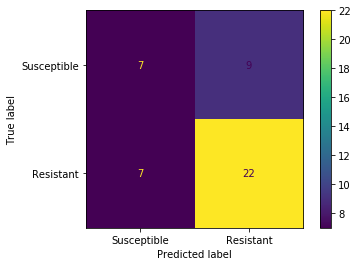

In [21]:
from sklearn.metrics import plot_confusion_matrix

bamboozle = plot_confusion_matrix(drug_model, X=X_test, y_true=y_test,
                                  display_labels=['Susceptible', 'Resistant'],
                                  include_values=True)

## Interpreting model using SHAP values

### Feature importance
This is a plot of mean absolute SHAP values per feature

In [22]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(drug_model, feature_pertubation='interventional', model_output='probability', data=X_train)


### Plot of SHAP values per Feature

In [23]:
shap.summary_plot(shap_raw, X_train, show=False, plot_size=(4, 5), color_bar_label='Feature Value')
# fig, ax = plt.gcf(), plt.gca()
# ax.set_xlabel('SHAP Value')
# plt.savefig(results / 'raw_shap.svg', dpi=1200, format='svg', bbox_inches='tight')

NameError: name 'shap_raw' is not defined